# ISIC Challenge 2018

One of the many applications of Convolutional Neural Networks is in Health Care. In this notebook we will look at the dataset provided for the 3rd task in the ISIC-2018 Challenge: The HAM10000 Dataset (c) by ViDIR Group, Department of Dermatology, Medical University of Vienna (https://arxiv.org/abs/1803.10417).

Challenge link: https://challenge.isic-archive.com/data/

Task 3 dataset download links: 

[training_data](https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip),
[training_labels](https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip)

[validation_data](https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip), 
[validation_labels](https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip)

[test_data](https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip)

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import shutil
import random
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import preprocessing
from keras import applications
from tensorflow.keras.utils import image_dataset_from_directory

from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

## Download and prepare the data

In [ ]:
dataset_links = {'training_data': 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip',
                 'training_labels': 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip',
                 'validation_data': 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip',
                 'validation_labels': 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip',
                 'test_data': 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip'}

In [ ]:
for key in dataset_links:
    tf.keras.utils.get_file(key+'.zip',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets',
                            extract=True)

420601856/420586171 [==============================] - 27s 0us/step


In [ ]:
folders = []
for folder, subfolder, file in os.walk('./datasets'):
    if not folder in folders:
        folders.append(folder)

In [ ]:
folders

['./datasets',
 './datasets/ISIC2018_Task3_Training_Input',
 './datasets/ISIC2018_Task3_Test_Input',
 './datasets/ISIC2018_Task3_Validation_Input',
 './datasets/ISIC2018_Task3_Validation_GroundTruth',
 './datasets/ISIC2018_Task3_Training_GroundTruth']

In [ ]:
paths = {'train_data':'./datasets/ISIC2018_Task3_Training_Input',
         'train_labels':'./datasets/ISIC2018_Task3_Training_GroundTruth',
         'test_data':'./datasets/ISIC2018_Task3_Validation_Input',
         'test_labels':'./datasets/ISIC2018_Task3_Validation_GroundTruth'}
paths

{'test_data': './datasets/ISIC2018_Task3_Validation_Input',
 'test_labels': './datasets/ISIC2018_Task3_Validation_GroundTruth',
 'train_data': './datasets/ISIC2018_Task3_Training_Input',
 'train_labels': './datasets/ISIC2018_Task3_Training_GroundTruth'}

In [ ]:
training_GT = pd.read_csv(paths['train_labels']+'/ISIC2018_Task3_Training_GroundTruth.csv')
test_GT = pd.read_csv(paths['test_labels']+'/ISIC2018_Task3_Validation_GroundTruth.csv')
training_GT.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
categories = np.array(training_GT.columns)[1:]
categories

array(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype=object)

## data 很不平衡

In [ ]:
training_GT.sum(axis=0)

image    ISIC_0024306ISIC_0024307ISIC_0024308ISIC_00243...
MEL                                                 1113.0
NV                                                  6705.0
BCC                                                  514.0
AKIEC                                                327.0
BKL                                                 1099.0
DF                                                   115.0
VASC                                                 142.0
dtype: object

In [ ]:
all(training_GT.sum(axis=1) == 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


True

In [ ]:
for ds in ['train_data', 'test_data']:
    for cat in categories:
        if not os.path.isdir(paths[ds]+'/'+cat):
            os.mkdir(paths[ds]+'/'+cat)

In [ ]:
for cat in categories:
    for image in training_GT[(training_GT[cat] == 1)]['image']:
        shutil.move(paths['train_data']+'/'+image+'.jpg', paths['train_data']+'/'+cat)

for cat in categories:
    for image in test_GT[(test_GT[cat] == 1)]['image']:
        shutil.move(paths['test_data']+'/'+image+'.jpg', paths['test_data']+'/'+cat)

### Explore the data

In [ ]:
from scipy import ndimage
from matplotlib.pyplot import imshow
from PIL import Image

In [ ]:
sample_images = []
for im in training_GT.sample(n=3)['image']:
    sample_images.append(Image.open(paths['train_data']+'/NV/'+im+'.jpg'))

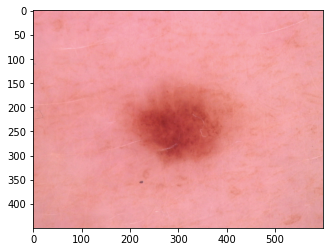

In [ ]:
imshow(sample_images[2])

### image_dataset_from_directory

In [ ]:
train_dataset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'training',
    validation_split = 0.1,
    batch_size = 128,
    crop_to_aspect_ratio = True)

valid_dataset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'validation',
    validation_split = 0.1,
    batch_size = 128,
    crop_to_aspect_ratio = True)

test_dataset = image_dataset_from_directory(
    paths['test_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    batch_size = 128,
    crop_to_aspect_ratio = True)

Found 10015 files belonging to 7 classes.
Using 9014 files for training.
Found 10015 files belonging to 7 classes.
Using 1001 files for validation.
Found 193 files belonging to 7 classes.


Training on the full datasets takes too long so we will work with a subset of the training dataset for the time being.

In [ ]:
train_miniset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical', 
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'training',
    validation_split = 0.6,
    batch_size = 4006,
    crop_to_aspect_ratio = True)

valid_miniset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'validation',
    validation_split = 0.6,
    batch_size = 128,
    crop_to_aspect_ratio = True)

Found 10015 files belonging to 7 classes.
Using 4006 files for training.
Found 10015 files belonging to 7 classes.
Using 6009 files for validation.


In [ ]:
for data_batch, labels_batch in train_miniset:
    train_data = data_batch 
    train_labels = labels_batch

print(train_data.shape)
print(train_labels.shape)

(4006, 180, 180, 3)
(4006, 7)


# Train a model from scratch

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
rescaled_inputs = layers.Rescaling(1./255)(inputs)

In [ ]:
x1 = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(rescaled_inputs)
x1 = layers.Flatten()(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(7, activation="softmax")(x1)

model_1 = keras.Model(inputs=inputs, outputs=x1)

model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history_1 = model_1.fit(train_data,
                        train_labels,
                        batch_size=128,
                        epochs=20,
                        validation_split=0.2,
                        callbacks=callback)

Epoch 1/20
26/26 [==============================] - 10s 49ms/step - loss: 4.9693 - accuracy: 0.5581 - val_loss: 1.1373 - val_accuracy: 0.6496
Epoch 2/20
26/26 [==============================] - 1s 36ms/step - loss: 1.0682 - accuracy: 0.6654 - val_loss: 1.0378 - val_accuracy: 0.6721
Epoch 3/20
26/26 [==============================] - 1s 34ms/step - loss: 0.9714 - accuracy: 0.6767 - val_loss: 0.9629 - val_accuracy: 0.6721
Epoch 4/20
26/26 [==============================] - 1s 36ms/step - loss: 0.9127 - accuracy: 0.6785 - val_loss: 0.8958 - val_accuracy: 0.6758
Epoch 5/20
26/26 [==============================] - 1s 34ms/step - loss: 0.8411 - accuracy: 0.6879 - val_loss: 0.8435 - val_accuracy: 0.6908
Epoch 6/20
26/26 [==============================] - 1s 34ms/step - loss: 0.7590 - accuracy: 0.7150 - val_loss: 0.9371 - val_accuracy: 0.6721
Epoch 7/20
26/26 [==============================] - 1s 35ms/step - loss: 0.7660 - accuracy: 0.7241 - val_loss: 0.8349 - val_accuracy: 0.7032
Epoch 8/20
2

In [ ]:
model_1.evaluate(valid_miniset)

47/47 [==============================] - 12s 219ms/step - loss: 0.8354 - accuracy: 0.6965


[0.8354357481002808, 0.6964552998542786]

In [ ]:
x2 = layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu")(rescaled_inputs)
x2 = layers.MaxPooling2D(pool_size=2)(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.Dense(7, activation="softmax")(x2)

model_2 = keras.Model(inputs=inputs, outputs=x2)

model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history_2 = model_2.fit(train_data,
                        train_labels,
                        batch_size=128,
                        epochs=20,
                        validation_split=0.2,
                        callbacks=callback)

Epoch 1/20
26/26 [==============================] - 2s 67ms/step - loss: 5.3032 - accuracy: 0.5668 - val_loss: 1.1055 - val_accuracy: 0.6708
Epoch 2/20
26/26 [==============================] - 1s 48ms/step - loss: 1.0668 - accuracy: 0.6760 - val_loss: 1.0000 - val_accuracy: 0.6708
Epoch 3/20
26/26 [==============================] - 1s 50ms/step - loss: 0.9619 - accuracy: 0.6829 - val_loss: 0.9966 - val_accuracy: 0.6696
Epoch 4/20
26/26 [==============================] - 1s 49ms/step - loss: 0.9135 - accuracy: 0.6820 - val_loss: 0.9306 - val_accuracy: 0.6708
Epoch 5/20
26/26 [==============================] - 1s 49ms/step - loss: 0.8490 - accuracy: 0.6919 - val_loss: 0.8910 - val_accuracy: 0.6658
Epoch 6/20
26/26 [==============================] - 1s 48ms/step - loss: 0.8291 - accuracy: 0.6973 - val_loss: 0.8916 - val_accuracy: 0.6683
Epoch 7/20
26/26 [==============================] - 1s 48ms/step - loss: 0.7436 - accuracy: 0.7331 - val_loss: 0.8616 - val_accuracy: 0.6808
Epoch 8/20
26

In [ ]:
model_2.evaluate(valid_miniset)

47/47 [==============================] - 12s 220ms/step - loss: 0.8342 - accuracy: 0.7043


[0.8342359662055969, 0.7042769193649292]

## Add augmentation

In [ ]:
augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                 layers.RandomRotation(0.5),
                                 layers.RandomZoom(0.1)
                                 ])

In [ ]:
x3 = augmentation(rescaled_inputs)
x3 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x3)
x3 = layers.MaxPooling2D(pool_size=2)(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dropout(0.5)(x3)
x3 = layers.Dense(7, activation="softmax")(x3)
model_3 = keras.Model(inputs=inputs, outputs=x3)

model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history = model_3.fit(train_data,
                      train_labels,
                      batch_size=128,
                      epochs=20,
                      validation_split=0.2,
                      callbacks=callback)

Epoch 1/20
26/26 [==============================] - 3s 68ms/step - loss: 8.5570 - accuracy: 0.5197 - val_loss: 2.3655 - val_accuracy: 0.6708
Epoch 2/20
26/26 [==============================] - 1s 54ms/step - loss: 1.2350 - accuracy: 0.6757 - val_loss: 0.9878 - val_accuracy: 0.6696
Epoch 3/20
26/26 [==============================] - 1s 56ms/step - loss: 0.9776 - accuracy: 0.6726 - val_loss: 1.0737 - val_accuracy: 0.6721
Epoch 4/20
26/26 [==============================] - 1s 56ms/step - loss: 0.9665 - accuracy: 0.6654 - val_loss: 0.9265 - val_accuracy: 0.6783
Epoch 5/20
26/26 [==============================] - 1s 54ms/step - loss: 0.9283 - accuracy: 0.6689 - val_loss: 0.9201 - val_accuracy: 0.6546
Epoch 6/20
26/26 [==============================] - 1s 54ms/step - loss: 0.9198 - accuracy: 0.6645 - val_loss: 0.9188 - val_accuracy: 0.6696
Epoch 7/20
26/26 [==============================] - 1s 56ms/step - loss: 0.9174 - accuracy: 0.6717 - val_loss: 0.8793 - val_accuracy: 0.6796
Epoch 8/20
26

In [ ]:
model_3.evaluate(valid_miniset)

47/47 [==============================] - 12s 219ms/step - loss: 0.8681 - accuracy: 0.6720


[0.8681325316429138, 0.6719920039176941]

### Ensembling

In [ ]:
x4 = layers.Average()([x1, x2, x3])
model_4 = keras.Model(inputs=inputs, outputs=x4)

model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_4.evaluate(valid_miniset)

47/47 [==============================] - 13s 223ms/step - loss: 0.8062 - accuracy: 0.7044


[0.8062325716018677, 0.7044433355331421]

The 3 models had comprable accuracy, though the 2nd and 3rd tend to perform better on new data. The accuracies I got on this run are:

1. model_1 accuracy: 0.6905
2. model_2 accuracy: 0.6930
3. model_3 accuracy: 0.7036

As you can see (and hopefully confirm for yourselves later on) the ensebmled model which simply averages over the output of the three performs even better with accuracy 0.7094.

## A deeper Convnet

In [ ]:
x5 = augmentation(rescaled_inputs)
x5 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x5)
x5 = layers.MaxPooling2D(pool_size=2)(x5)
x5 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x5)
x5 = layers.MaxPooling2D(pool_size=2)(x5)
x5 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x5)
x5 = layers.MaxPooling2D(pool_size=2)(x5)
x5 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x5)
x5 = layers.MaxPooling2D(pool_size=2)(x5)
x5 = layers.Flatten()(x5)
x5 = layers.Dropout(0.5)(x5)
x5 = layers.Dense(7, activation="softmax")(x5)

model_5 = keras.Model(inputs=inputs, outputs=x5)

model_5.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [ ]:
[model_5.layers[3].get_weights()[i].shape for i in range(2)]

[(3, 3, 3, 32), (32,)]

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history = model_5.fit(train_data,
                      train_labels,
                      batch_size=128,
                      epochs=20,
                      validation_split=0.2,
                      callbacks=callback)

Epoch 1/20
26/26 [==============================] - 4s 111ms/step - loss: 1.1472 - accuracy: 0.6526 - val_loss: 1.0200 - val_accuracy: 0.6708
Epoch 2/20
26/26 [==============================] - 2s 94ms/step - loss: 1.0015 - accuracy: 0.6767 - val_loss: 0.9793 - val_accuracy: 0.6708
Epoch 3/20
26/26 [==============================] - 2s 93ms/step - loss: 0.9799 - accuracy: 0.6767 - val_loss: 0.9711 - val_accuracy: 0.6708
Epoch 4/20
26/26 [==============================] - 2s 93ms/step - loss: 0.9604 - accuracy: 0.6767 - val_loss: 1.0534 - val_accuracy: 0.6708
Epoch 5/20
26/26 [==============================] - 2s 92ms/step - loss: 0.9697 - accuracy: 0.6767 - val_loss: 1.0951 - val_accuracy: 0.6708
Epoch 6/20
26/26 [==============================] - 2s 94ms/step - loss: 0.9464 - accuracy: 0.6760 - val_loss: 0.8989 - val_accuracy: 0.6733
Epoch 7/20
26/26 [==============================] - 2s 92ms/step - loss: 0.9095 - accuracy: 0.6763 - val_loss: 0.8730 - val_accuracy: 0.6721
Epoch 8/20
2

In [ ]:
model_5.evaluate(valid_miniset)

47/47 [==============================] - 13s 225ms/step - loss: 0.8265 - accuracy: 0.7003


[0.8264745473861694, 0.7002829313278198]

# Transfer learning

In [ ]:
model_xception = keras.applications.Xception(
    weights='imagenet',
    input_shape=(180,180,3),
    include_top=False)

83697664/83683744 [==============================] - 3s 0us/step


In [ ]:
model_xception.summary()

## Poor man's transfer learning

As you no doubt have experienced, fine tuning or fully retraining a model transferred from large convnets is computationally very expensive, especially during developement when you need to train many variations of your model. If you don't have access to GPUs, you can restrict yourself to using the pretrained model for feature extraction only and develope the "top" of the model which may not even have convolutional layers.

### Using Xception

In [ ]:
model_xception.output_shape

In [ ]:
# Pass the images through the pretrained model to obtain their
# feature representation as well as their corresponding labels.
train_data_xception = np.zeros(shape=(0,6,6,2048), dtype='float32')
train_labels_xception = np.zeros(shape=(0,7), dtype='float32')
for images, labels in train_dataset:
    train_data_xception = np.concatenate([train_data_xception, model_xception.predict(images)], axis=0)
    train_labels_xception = np.concatenate([train_labels_xception, labels], axis=0)

In [ ]:
print(train_data_xception.shape)
print(train_labels_xception.shape)

In [ ]:
# Process validation and test datasets as well.
valid_data_xception = np.zeros(shape=(0,6,6,2048), dtype='float32')
valid_labels_xception = np.zeros(shape=(0,7), dtype='float32')
for images, labels in valid_dataset:
    valid_data_xception = np.concatenate([valid_data_xception, model_xception.predict(images)], axis=0)
    valid_labels_xception = np.concatenate([valid_labels_xception, labels], axis=0)

test_data_xception = np.zeros(shape=(0,6,6,2048), dtype='float32')
test_labels_xception = np.zeros(shape=(0,7), dtype='float32')
for images, labels in test_dataset:
    test_data_xception = np.concatenate([test_data_xception, model_xception.predict(images)], axis=0)
    test_labels_xception = np.concatenate([test_labels_xception, labels], axis=0)

Using the pre-trained Xception model we have extracted 2048 features, represented as 6x6 matrices, for each image in our training dataset. Thus the input shape for out new model is (6, 6, 2048). 

In [ ]:
t_xc_inputs = keras.Input(shape=(6,6,2048))
t_xc_outputs = layers.GlobalAveragePooling2D()(t_xc_inputs)
t_xc_outputs = layers.Dense(1024, activation='relu')(t_xc_outputs)
t_xc_outputs = layers.Dense(7, activation='softmax')(t_xc_outputs)
model_t_xc = keras.Model(inputs = t_xc_inputs, outputs = t_xc_outputs)
model_t_xc.compile(loss="categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

In [ ]:
model_t_xc.summary()

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history_t1 = model_t_xc.fit(train_data_xception, train_labels_xception, 
                            validation_data=(valid_data_xception,
                                             valid_labels_xception),
                            epochs=20, batch_size=32,
                            callbacks=callback)

In [ ]:
model_t_xc.evaluate(test_data_xception, test_labels_xception)

### Using VGG16

In [ ]:
model_vgg16 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
model_vgg16.summary()

In [ ]:
model_vgg16.output_shape

In [ ]:
# Pass the images through the pretrained model to obtain their
# feature representation as well as their corresponding labels.
train_data_vgg16 = np.zeros(shape=(0,5,5,512), dtype='float32')
train_labels_vgg16 = np.zeros(shape=(0,7), dtype='float32')
for images, labels in train_dataset:
    train_data_vgg16 = np.concatenate([train_data_vgg16, model_vgg16.predict(images)], axis=0)
    train_labels_vgg16 = np.concatenate([train_labels_vgg16, labels], axis=0)

In [ ]:
valid_data_vgg16 = np.zeros(shape=(0,5,5,512), dtype='float32')
valid_labels_vgg16 = np.zeros(shape=(0,7), dtype='float32')
for images, labels in valid_dataset:
    valid_data_vgg16 = np.concatenate([valid_data_vgg16, model_vgg16.predict(images)], axis=0)
    valid_labels_vgg16 = np.concatenate([valid_labels_vgg16, labels], axis=0)

test_data_vgg16 = np.zeros(shape=(0,5,5,512), dtype='float32')
test_labels_vgg16 = np.zeros(shape=(0,7), dtype='float32')
for images, labels in test_dataset:
    test_data_vgg16 = np.concatenate([test_data_vgg16, model_vgg16.predict(images)], axis=0)
    test_labels_vgg16 = np.concatenate([test_labels_vgg16, labels], axis=0)

In [ ]:
t_vgg16_inputs = keras.Input(shape=(6,6,2048))
t_vgg16_outputs = layers.Conv2D(512, 11)(t_vgg16_inputs)
t_vgg16_outputs = layers.GlobalAveragePooling2D()(t_vgg16_outputs)
t_vgg16_outputs = layers.Dense(7, activation='softmax')(t_vgg16_outputs)
model_t_vgg16 = keras.Model(inputs = t_vgg16_inputs, outputs = t_vgg16_outputs)
model_t_vgg16.compile(loss="categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

model_t_vgg16.summary()

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

history_t2 = model_t_vgg16.fit(train_data_vgg16, train_labels_vgg16,
                               validation_data=(valid_data_vgg16,
                                                valid_labels_vgg16),
                               epochs=20, batch_size=32, callbacks=callback)

In [ ]:
history_t2 = model_t_vgg16.fit(train_miniset,
                               epochs=10)

## 分割线

以下是老版本notebook的内容：

In [ ]:
train_miniset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'training',
    validation_split = 0.9,
    batch_size = 32,
    crop_to_aspect_ratio = True)

valid_miniset = image_dataset_from_directory(
    paths['train_data'],
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (180, 180),
    shuffle = True,
    seed = 0,
    subset = 'validation',
    validation_split = 0.9,
    batch_size = 32,
    crop_to_aspect_ratio = True)

Found 10015 files belonging to 7 classes.
Using 1002 files for training.
Found 10015 files belonging to 7 classes.
Using 9013 files for validation.


In [ ]:
# Recall that we already have our input layer and normalization layer:
#inputs = keras.Input(shape=(180, 180, 3))
#rescaled_inputs = layers.Rescaling(1./255)(inputs)

y1 = model_xception(rescaled_inputs)
y1 = layers.GlobalAveragePooling2D()(y1)
y1 = layers.Dense(7, activation="softmax")(y1)
model_t_xc = keras.Model(inputs=inputs, outputs=y1)

model_t_xc.compile(loss="categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

In [ ]:
model_t_xc.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
__________________________________________

In [ ]:
model_xception.trainable = False

In [ ]:
history_t1 = model_t_xc.fit(train_miniset, 
                            validation_data=valid_miniset,
                            epochs=1)

32/32 [==============================] - 34s 930ms/step - loss: 0.9931 - accuracy: 0.6617 - val_loss: 2.3895 - val_accuracy: 0.6697


In [ ]:
model_xception.trainable = True

In [ ]:
history_t1 = model_t_xc.fit(train_miniset, 
                            validation_data=valid_miniset,
                            epochs=1)

32/32 [==============================] - 28s 883ms/step - loss: 0.5974 - accuracy: 0.7794 - val_loss: 3.3551 - val_accuracy: 0.6888


In [ ]:
model_vgg16 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
#inputs = keras.Input(shape=(180, 180, 3))
#rescaled_inputs = layers.Rescaling(1./255)(inputs)

y2 = model_vgg16(rescaled_inputs)
y2 = layers.Flatten()(y2)
y2 = layers.Dense(7, activation="softmax")(y2)
model_t_vgg16 = keras.Model(inputs=inputs, outputs=y2)

model_t_vgg16.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

In [ ]:
model_vgg16.trainable = True
for layer in model_vgg16.layers[:-4]:
    layer.trainable = False

In [ ]:
history_t2 = model_t_vgg16.fit(train_miniset,
                               epochs=10)

Epoch 1/10
32/32 [==============================] - 8s 177ms/step - loss: 2.1909 - accuracy: 0.6188
Epoch 2/10
32/32 [==============================] - 6s 156ms/step - loss: 1.1662 - accuracy: 0.6747
Epoch 3/10
32/32 [==============================] - 6s 154ms/step - loss: 1.1396 - accuracy: 0.6747
Epoch 4/10
32/32 [==============================] - 6s 157ms/step - loss: 1.1557 - accuracy: 0.6747
Epoch 5/10
32/32 [==============================] - 6s 154ms/step - loss: 1.1424 - accuracy: 0.6747
Epoch 6/10
32/32 [==============================] - 6s 156ms/step - loss: 1.1472 - accuracy: 0.6747
Epoch 7/10
32/32 [==============================] - 6s 156ms/step - loss: 1.1512 - accuracy: 0.6747
Epoch 8/10
32/32 [==============================] - 6s 155ms/step - loss: 1.1533 - accuracy: 0.6747
Epoch 9/10
32/32 [==============================] - 6s 156ms/step - loss: 1.1404 - accuracy: 0.6747
Epoch 10/10
32/32 [==============================] - 6s 154ms/step - loss: 1.1613 - accuracy: 0.6747

## Ensembling